# Setting up Media Pipe

In [3]:
# Importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils # Drawing Utilites
mp_pose = mp.solutions.pose # Pose
mp_holistic = mp.solutions.holistic # Holistic
%matplotlib inline

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False # Image is no longer writeable
    results = model.process(image) # Make prediction
    image.flags.writeable = True # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
class Rating:
    def __init__(self,a,b,c):
        self.a = np.array(a)
        self.b = np.array(b)
        self.c = np.array(c)
        self.radians = np.arctan2(self.c[1]-self.b[1], self.c[0]-self.b[0]) - np.arctan2(self.a[1]-self.b[1], self.a[0]-self.b[0])
        self.angle = np.abs(self.radians*180.0/np.pi)
        
    def calculate_angle(self):
        if self.angle > 180.0:
            self.angle = 360-self.angle
            
        return self.angle

Angle of split: 165.04578633929745
Angle of back: 117.28420729362307


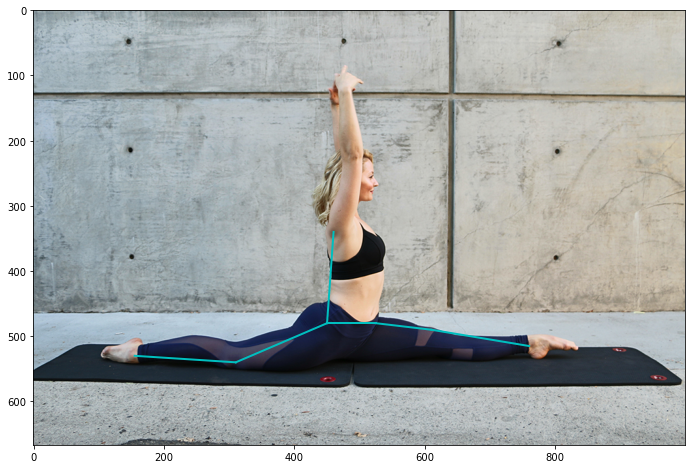

In [43]:
plt.figure(figsize=(12,8))

image = cv2.imread('Split_1.jpeg')

plt.plot([155,310],[530,540],'c',linewidth=2) # Left ankle and Left knee
plt.plot([450,310],[480,540],'c',linewidth=2) # Left knee and Left hip
plt.plot([450,460],[480,340],'c',linewidth=2) # Left hip and Left shoulder
plt.plot([450,525],[480,480],'c',linewidth=2) # Left hip and Right hip
plt.plot([610,525],[490,480],'c',linewidth=2) # Right hip and Right knee
plt.plot([610,760],[490,515],'c',linewidth=2) # Right hip and Right ankle

# Calculate angle
splitLeftAngle = Rating([310,540],[450,480],[525,480])
split_left_angle1 = splitLeftAngle.calculate_angle()

splitRightAngle = Rating([610,490],[525,480],[450,480])
split_right_angle1 = splitRightAngle.calculate_angle()

split_angle1 = (split_left_angle1 + split_right_angle1)/2

backAngle = Rating([310,540],[450,480],[460,340])
back_angle1 = backAngle.calculate_angle()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("Angle of split: " + str(split_angle1))
print("Angle of back: " + str(back_angle1))

Angle of split: 160.74476173046725
Angle of back: 121.58726518971746


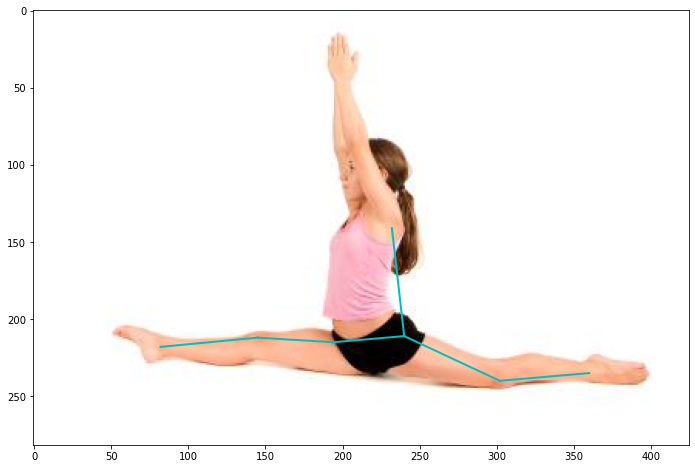

In [44]:
plt.figure(figsize=(12,8))

image = cv2.imread('Split_2.jpeg')

plt.plot([82,145],[218,212],'c',linewidth=2) # Left ankle and Left knee
plt.plot([194,145],[215,212],'c',linewidth=2) # Left knee and Left hip
plt.plot([194,240],[215,211],'c',linewidth=2) # Left hip and Right hip
plt.plot([232,240],[141,211],'c',linewidth=2) # Right hip and Right shoulder
plt.plot([302,240],[240,211],'c',linewidth=2) # Right hip and Right knee
plt.plot([302,360],[240,235],'c',linewidth=2) # Right hip and Right ankle

# Calculate angle
splitLeftAngle = Rating([145,212],[194,215],[240,211])
split_left_angle2 = splitLeftAngle.calculate_angle()

splitRightAngle = Rating([302,240],[240,211],[194,215])
split_right_angle2 = splitRightAngle.calculate_angle()

split_angle2 = (split_left_angle2 + split_right_angle2)/2

backAngle = Rating([302,240],[240,211],[232,141])
back_angle2 = backAngle.calculate_angle()

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("Angle of split: " + str(split_angle2))
print("Angle of back: " + str(back_angle2))

In [45]:
print("Angle of split:",(split_angle1 + split_angle2)/2)
print(f"Angle of back:",(back_angle1 + back_angle2)/2)

Angle of split: 162.89527403488233
Angle of back: 119.43573624167027


Angle of split: 176.76029970389789
Angle of back: 81.40186579500747


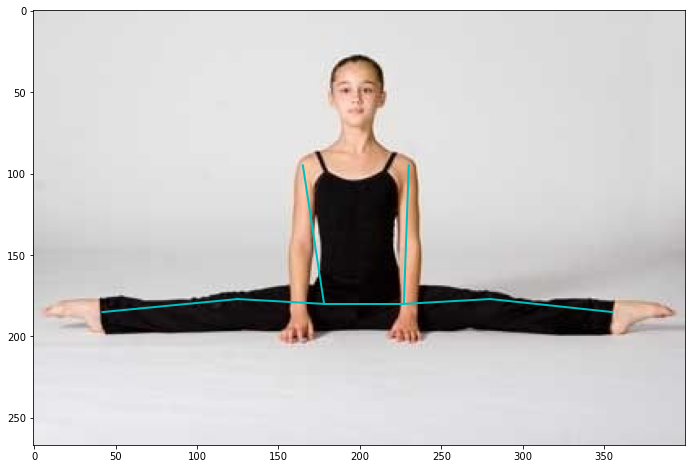

In [39]:
plt.figure(figsize=(12,8))

image = cv2.imread('Split_3.jpeg')

plt.plot([42,125],[185,177],'c',linewidth=2) # Left ankle and Left knee
plt.plot([178,125],[180,177],'c',linewidth=2) # Left knee and Left hip
plt.plot([178,165],[180,95],'c',linewidth=2) # Left hip and Left Shoulder
plt.plot([178,227],[180,180],'c',linewidth=2) # Left hip and Right hip
plt.plot([230,227],[95,180],'c',linewidth=2) # Right hip and Right shoulder
plt.plot([280,227],[177,180],'c',linewidth=2) # Right hip and Right knee
plt.plot([280,355],[177,185],'c',linewidth=2) # Right hip and Right ankle

# Calculate angle
splitLeftAngle = Rating([125,177],[178,180],[227,180])
split_left_angle3 = splitLeftAngle.calculate_angle()

splitRightAngle = Rating([280,177],[227,180],[178,180])
split_right_angle3 = splitRightAngle.calculate_angle()

split_angle3 = (split_left_angle3 + split_right_angle3)/2

backAngle_left = Rating([125,177],[178,180],[165,95])
backAngle_right = Rating([280,177],[227,180],[230,95])
back_angle_left3 = backAngle_left.calculate_angle()
back_angle_right3 = backAngle_right.calculate_angle()

back_angle3 = (back_angle_left3 + back_angle_right3)/2

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("Angle of split: " + str(split_angle3))
print("Angle of back: " + str(back_angle3))

# Real Time Splits Detection

In [46]:
class Rating:
    def __init__(self,a,b,c):
        self.a = np.array(a)
        self.b = np.array(b)
        self.c = np.array(c)
        self.radians = np.arctan2(self.c[1]-self.b[1], self.c[0]-self.b[0]) - np.arctan2(self.a[1]-self.b[1], self.a[0]-self.b[0])
        self.angle = np.abs(self.radians*180.0/np.pi)
        
    def calculate_angle(self):
        if self.angle > 180.0:
            self.angle = 360-self.angle
            
        return self.angle
    
    def calculate_rating_front_splits(self):
        if self.angle >= 176.76:
            percentage = 100 * (176.76/self.angle)
        else:
            self.angle = 353.52 - self.angle
            percentage = 100 * (176.6/self.angle)
        
        return percentage
    
    def calculate_rating_side_splits(self):
        if self.angle >= 162.9:
            percentage = 100 * (162.9/self.angle)
        else:
            self.angle = 325.8 - self.angle
            percentage = 100 * (162.9/self.angle)
        
        return percentage
    
    def calculate_rating_front_splits_back(self):
        if self.angle >= 81.4:
            percentage = 100 * (81.4/self.angle)
        else:
            self.angle = 162.8 - self.angle
            percentage = 100 * (81.4/self.angle)
        
        return percentage
    
    def calculate_rating_side_splits_back(self):
        if self.angle >= 119.44:
            percentage = 100 * (119.44/self.angle)
        else:
            self.angle = 238.88 - self.angle
            percentage = 100 * (119.44/self.angle)
        
        return percentage

In [49]:
def draw_styled_landmarks_front_splits(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, [list(mp_holistic.POSE_CONNECTIONS)[7], list(mp_holistic.POSE_CONNECTIONS)[29], list(mp_holistic.POSE_CONNECTIONS)[13], list(mp_holistic.POSE_CONNECTIONS)[10], list(mp_holistic.POSE_CONNECTIONS)[5], list(mp_holistic.POSE_CONNECTIONS)[27], list(mp_holistic.POSE_CONNECTIONS)[33], list(mp_holistic.POSE_CONNECTIONS)[18], list(mp_holistic.POSE_CONNECTIONS)[8]], 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=3, circle_radius=3)
                             )
    
def draw_styled_landmarks_side_splits_right(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, [list(mp_holistic.POSE_CONNECTIONS)[7], list(mp_holistic.POSE_CONNECTIONS)[29], list(mp_holistic.POSE_CONNECTIONS)[13], list(mp_holistic.POSE_CONNECTIONS)[10], list(mp_holistic.POSE_CONNECTIONS)[5], list(mp_holistic.POSE_CONNECTIONS)[27], list(mp_holistic.POSE_CONNECTIONS)[33], list(mp_holistic.POSE_CONNECTIONS)[18]], 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=3, circle_radius=3)
                             )
    
def draw_styled_landmarks_side_splits_left(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, [list(mp_holistic.POSE_CONNECTIONS)[7], list(mp_holistic.POSE_CONNECTIONS)[29], list(mp_holistic.POSE_CONNECTIONS)[13], list(mp_holistic.POSE_CONNECTIONS)[10], list(mp_holistic.POSE_CONNECTIONS)[5], list(mp_holistic.POSE_CONNECTIONS)[27], list(mp_holistic.POSE_CONNECTIONS)[33], list(mp_holistic.POSE_CONNECTIONS)[8]], 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=3, circle_radius=3)
                             )

In [51]:
# Front Splits

cap = cv2.VideoCapture(0)

# Access mediapipe model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
# Set mediapipe model 
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make Detections
        results = pose.process(image)
        
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw landmarks
        draw_styled_landmarks_front_splits(image, results)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            
            # Calculate percentage
            obj_right = Rating(right_knee,right_hip,left_hip)
            right_percentage = obj_right.calculate_rating_front_splits()
            
            obj_left = Rating(left_knee,left_hip,right_hip)
            left_percentage = obj_left.calculate_rating_front_splits()
            
            percentage = (right_percentage + left_percentage)/2
            
            obj_back_right = Rating(right_knee,right_hip,right_shoulder)
            back_angle_right = obj_back_right.calculate_angle()
            back_percentage_right = obj_back_right.calculate_rating_front_splits_back()
            
            obj_back_left = Rating(left_knee,left_hip,left_shoulder)
            back_angle_left = obj_back_left.calculate_angle()
            back_percentage_left = obj_back_left.calculate_rating_front_splits_back()

            back_percentage = (back_percentage_right + back_percentage_left)/2
            
            # Display Green or Red Message
            if percentage > 80 and back_percentage > 80:
                cv2.putText(image, "Perfect!", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 128, 0), 2, cv2.LINE_AA
                                )
            elif percentage < 80:
                cv2.putText(image, "Lower your hips", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                                )
            elif (back_percentage_right < 80 and back_angle_right > 90) or (back_percentage_left < 80 and back_angle_left > 90):
                cv2.putText(image, "Move your back forward", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                               )
            elif (back_percentage_right < 80 and back_angle_right < 90) or (back_percentage_left < 80 and back_angle_left < 90):
                cv2.putText(image, "Move your back backward", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                               )
        except:
            pass
        
        # Rectangle Setup on Top
        cv2.rectangle(image, (0,0), (10000,80), (245,117,16), -1)

        # Display Leg Accuarcy
        cv2.putText(image, 'Split Accuarcy', (300,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(percentage, 2)) + '%', 
                    (300,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,127,250), 2, cv2.LINE_AA)

        # Display Back Accuarcy
        cv2.putText(image, 'Back Accuarcy', (800,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(back_percentage, 2)) + '%', 
                    (800,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,127,250), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

In [57]:
# Side Splits Right

cap = cv2.VideoCapture(0)

# Access mediapipe model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
# Set mediapipe model 
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make Detections
        results = pose.process(image)
        
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw landmarks
        draw_styled_landmarks_side_splits_right(image, results)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            
            # Calculate percentage
            obj_right = Rating(right_knee,right_hip,left_hip)
            right_percentage = obj_right.calculate_rating_side_splits()
            
            obj_left = Rating(left_knee,left_hip,right_hip)
            left_percentage = obj_left.calculate_rating_side_splits()
            
            percentage = (right_percentage + left_percentage)/2
            
            obj_back_right = Rating(right_knee,right_hip,right_shoulder)
            back_angle_right = obj_back_right.calculate_angle()
            back_percentage_right = obj_back_right.calculate_rating_side_splits_back()
            
            # Display Green or Red Message
            if percentage > 80 and back_percentage_right > 80:
                cv2.putText(image, "Perfect!", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 128, 0), 2, cv2.LINE_AA
                                )
            elif percentage < 80:
                cv2.putText(image, "Lower your hips", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                                )
            elif back_percentage_right < 80 and back_angle_right > 90:
                cv2.putText(image, "Move your back forward", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                               )
            elif back_percentage_right < 80 and back_angle_right < 90:
                cv2.putText(image, "Move your back backward", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                               )
        except:
            pass
        
        # Rectangle Setup on Top
        cv2.rectangle(image, (0,0), (10000,80), (245,117,16), -1)

        # Display Leg Accuarcy
        cv2.putText(image, 'Split Accuarcy', (300,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(percentage, 2)) + '%', 
                    (300,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,127,250), 2, cv2.LINE_AA)

        # Display Back Accuarcy
        cv2.putText(image, 'Back Accuarcy', (800,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(back_percentage_right, 2)) + '%', 
                    (800,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,127,250), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

In [54]:
# Side Splits Left

cap = cv2.VideoCapture(0)

# Access mediapipe model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
# Set mediapipe model 
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # Make Detections
        results = pose.process(image)
        
        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Draw landmarks
        draw_styled_landmarks_side_splits_left(image, results)
        
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            
            # Get coordinates
            right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            
            # Calculate percentage
            obj_right = Rating(right_knee,right_hip,left_hip)
            right_percentage = obj_right.calculate_rating_side_splits()
            
            obj_left = Rating(left_knee,left_hip,right_hip)
            left_percentage = obj_left.calculate_rating_side_splits()
            
            percentage = (right_percentage + left_percentage)/2
            
            obj_back_left = Rating(left_knee,left_hip,left_shoulder)
            back_angle_left = obj_back_left.calculate_angle()
            back_percentage_left = obj_back_left.calculate_rating_side_splits_back()
            
            # Display Green or Red Message
            if percentage > 80 and back_percentage_left > 80:
                cv2.putText(image, "Perfect!", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 128, 0), 2, cv2.LINE_AA
                                )
            elif percentage < 80:
                cv2.putText(image, "Lower your hips", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                                )
            elif back_percentage_left < 80 and back_angle_left > 90:
                cv2.putText(image, "Move your back forward", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                               )
            elif back_percentage_left < 80 and back_angle_left < 90:
                cv2.putText(image, "Move your back backward", 
                           tuple(np.multiply(left_hip, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                               )
        except:
            pass
        
        # Rectangle Setup on Top
        cv2.rectangle(image, (0,0), (10000,80), (245,117,16), -1)

        # Display Leg Accuarcy
        cv2.putText(image, 'Split Accuarcy', (300,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(percentage, 2)) + '%', 
                    (300,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,127,250), 2, cv2.LINE_AA)

        # Display Back Accuarcy
        cv2.putText(image, 'Back Accuarcy', (800,12), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)
        cv2.putText(image, str(round(back_percentage_left, 2)) + '%', 
                    (800,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,127,250), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()